In [ ]:
# ============================================================
# 0) SETUP: Imports + Reproducibility
# ============================================================
import os, re, glob, shutil, hashlib, random
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# ============================================================
# 1) MOUNT DRIVE
# ============================================================
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# ============================================================
# 2) PATHS (Edit if your Drive folder name differs)
# ============================================================
ZIP_PATH = "/content/drive/MyDrive/Data/LC25000.zip"   # <-- your same location
EXTRACT_TO = "/content/LC25000"
LUNG_ROOT = "/content/LC25000/lung_image_sets"

# Clean split output (created each run)
SPLIT_ROOT_CLEAN = "/content/lung_data_clean"

# Outputs saved to Drive
OUT_DIR = "/content/drive/MyDrive/LungCancer_Project/outputs_figures"
os.makedirs(OUT_DIR, exist_ok=True)

MODEL_DIR = "/content/drive/MyDrive/LungCancer_Project/models"
os.makedirs(MODEL_DIR, exist_ok=True)

RESULTS_DIR = "/content/drive/MyDrive/LungCancer_Project/results"
os.makedirs(RESULTS_DIR, exist_ok=True)

print("ZIP exists?", os.path.exists(ZIP_PATH))



ZIP exists? True


In [ ]:
# ============================================================
# 3) UNZIP DATA
# ============================================================
import zipfile

if not os.path.exists(EXTRACT_TO):
    os.makedirs(EXTRACT_TO, exist_ok=True)

if not os.path.exists(LUNG_ROOT):
    print("Unzipping...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_TO)

print("Lung root exists:", os.path.exists(LUNG_ROOT))
print("Classes:", os.listdir(LUNG_ROOT))


Unzipping...
Lung root exists: True
Classes: ['lung_aca', 'lung_n', 'lung_scc']


In [ ]:
# ============================================================
# 4) CLEAN SPLIT (HASH DE-DUP) + NO OVERLAP train/valid/test
#    - Creates /content/lung_data_clean/{train,valid,test}/{class}/...
# ============================================================
from collections import defaultdict

def md5_file(path, chunk_size=8192):
    h = hashlib.md5()
    with open(path, "rb") as f:
        while True:
            b = f.read(chunk_size)
            if not b:
                break
            h.update(b)
    return h.hexdigest()

def list_images(root):
    exts = (".jpg",".jpeg",".png",".bmp",".tif",".tiff")
    files = []
    for cls in sorted(os.listdir(root)):
        cls_dir = os.path.join(root, cls)
        if os.path.isdir(cls_dir):
            for fp in glob.glob(os.path.join(cls_dir, "*")):
                if fp.lower().endswith(exts):
                    files.append((cls, fp))
    return files

def make_clean_splits(
    lung_root=LUNG_ROOT,
    out_root=SPLIT_ROOT_CLEAN,
    train_ratio=0.70,
    valid_ratio=0.15,
    test_ratio=0.15,
    seed=SEED
):
    assert abs(train_ratio + valid_ratio + test_ratio - 1.0) < 1e-6

    # reset output
    if os.path.exists(out_root):
        shutil.rmtree(out_root)
    os.makedirs(out_root, exist_ok=True)

    # collect all files by class
    all_files = list_images(lung_root)
    by_class = defaultdict(list)
    for cls, fp in all_files:
        by_class[cls].append(fp)

    # Create hash->(cls, file) and keep one per hash globally (removes duplicates)
    hash_map = {}
    kept = []
    for cls in sorted(by_class.keys()):
        for fp in by_class[cls]:
            h = md5_file(fp)
            if h not in hash_map:
                hash_map[h] = fp
                kept.append((cls, fp, h))

    # split per class (stratified)
    rng = random.Random(seed)
    split_counts = {}
    for cls in sorted(by_class.keys()):
        cls_kept = [(c, f, h) for (c, f, h) in kept if c == cls]
        rng.shuffle(cls_kept)

        n = len(cls_kept)
        n_train = int(n * train_ratio)
        n_valid = int(n * valid_ratio)
        n_test = n - n_train - n_valid

        train_items = cls_kept[:n_train]
        valid_items = cls_kept[n_train:n_train+n_valid]
        test_items  = cls_kept[n_train+n_valid:]

        split_counts[cls] = (len(train_items), len(valid_items), len(test_items))

        for split_name, items in [("train", train_items), ("valid", valid_items), ("test", test_items)]:
            out_cls = os.path.join(out_root, split_name, cls)
            os.makedirs(out_cls, exist_ok=True)
            for _, src, _ in items:
                dst = os.path.join(out_cls, os.path.basename(src))
                shutil.copy2(src, dst)

    return kept, split_counts

kept, split_counts = make_clean_splits()
print("✅ Unique images kept:", len(kept))
print("✅ Clean split created at:", SPLIT_ROOT_CLEAN)
print("✅ Split folders:", os.listdir(SPLIT_ROOT_CLEAN))
print("Per-class counts (train, valid, test):", split_counts)



✅ Unique images kept: 14195
✅ Clean split created at: /content/lung_data_clean
✅ Split folders: ['train', 'valid', 'test']
Per-class counts (train, valid, test): {'lung_aca': (3308, 709, 710), 'lung_n': (3320, 711, 713), 'lung_scc': (3306, 708, 710)}


In [ ]:
# ============================================================
# 5) VERIFY NO OVERLAP BETWEEN SPLITS (MD5 exact)
# ============================================================
def get_hashes_in_split(split_dir):
    files = []
    for cls in sorted(os.listdir(split_dir)):
        cls_dir = os.path.join(split_dir, cls)
        for fp in glob.glob(os.path.join(cls_dir, "*")):
            if os.path.isfile(fp):
                files.append(fp)
    hashes = defaultdict(list)
    for fp in files:
        h = md5_file(fp)
        hashes[h].append(fp)
    return hashes

train_hashes = get_hashes_in_split(os.path.join(SPLIT_ROOT_CLEAN, "train"))
valid_hashes = get_hashes_in_split(os.path.join(SPLIT_ROOT_CLEAN, "valid"))
test_hashes  = get_hashes_in_split(os.path.join(SPLIT_ROOT_CLEAN, "test"))

train_set = set(train_hashes.keys())
valid_set = set(valid_hashes.keys())
test_set  = set(test_hashes.keys())

print("train ∩ valid:", len(train_set & valid_set))
print("train ∩ test :", len(train_set & test_set))
print("valid ∩ test :", len(valid_set & test_set))
assert len(train_set & valid_set) == 0
assert len(train_set & test_set) == 0
assert len(valid_set & test_set) == 0
print("✅ No overlap confirmed.")


train ∩ valid: 0
train ∩ test : 0
valid ∩ test : 0
✅ No overlap confirmed.


In [ ]:
# ============================================================
# 6) DATA GENERATORS (MATCHED SETTINGS)
# ============================================================
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_SIZE = 160
BATCH_SIZE = 32

train_dir = os.path.join(SPLIT_ROOT_CLEAN, "train")
valid_dir = os.path.join(SPLIT_ROOT_CLEAN, "valid")
test_dir  = os.path.join(SPLIT_ROOT_CLEAN, "test")

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.10,
    horizontal_flip=True
)

valid_test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)

valid_ds = valid_test_gen.flow_from_directory(
    valid_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_ds = valid_test_gen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

class_names = list(train_ds.class_indices.keys())
print("Class indices:", train_ds.class_indices)


Found 9934 images belonging to 3 classes.
Found 2128 images belonging to 3 classes.
Found 2133 images belonging to 3 classes.
Class indices: {'lung_aca': 0, 'lung_n': 1, 'lung_scc': 2}


In [ ]:
# ============================================================
# 7) BUILD MobileNetV2 MODEL (Transfer Learning)
# ============================================================
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

NUM_CLASSES = len(class_names)

base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # Stage 1: freeze

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

model.summary()



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# ============================================================
# 8) CALLBACKS + SAVE PATHS
# ============================================================
BEST_LOCAL = "/content/best_mobilenetv2_clean.keras"
BEST_DRIVE = os.path.join(MODEL_DIR, "best_mobilenetv2_clean.keras")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        BEST_LOCAL, monitor="val_accuracy",
        save_best_only=True, mode="max", verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=4,
        restore_best_weights=True, verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, verbose=1
    )
]


In [ ]:
# ============================================================
# 9) STAGE 1 TRAIN (Head only)
# ============================================================
EPOCHS_STAGE1 = 6

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history1 = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS_STAGE1,
    callbacks=callbacks,
    verbose=1
)

print("✅ Stage 1 done. Saving best model to Drive...")
model.save(BEST_DRIVE)
print("Saved:", BEST_DRIVE)


# ============================================================

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.5793 - loss: 0.9719
Epoch 1: val_accuracy improved from -inf to 0.89709, saving model to /content/best_mobilenetv2_clean.keras
311/311 ━━━━━━━━━━━━━━━━━━━━ 145s 405ms/step - accuracy: 0.5798 - loss: 0.9709 - val_accuracy: 0.8971 - val_loss: 0.2678 - learning_rate: 1.0000e-04
Epoch 2/6
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.8679 - loss: 0.3369
Epoch 2: val_accuracy improved from 0.89709 to 0.91964, saving model to /content/best_mobilenetv2_clean.keras
311/311 ━━━━━━━━━━━━━━━━━━━━ 94s 301ms/step - accuracy: 0.8679 - loss: 0.3368 - val_accuracy: 0.9196 - val_loss: 0.2082 - learning_rate: 1.0000e-04
Epoch 3/6
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9082 - loss: 0.2444
Epoch 3: val_accuracy improved from 0.91964 to 0.92998, saving model to /content/best_mobilenetv2_clean.keras
311/311 ━━━━━━━━━━━━━━━━━━━━ 94s 301ms/step - accuracy: 0.9082 - loss: 0.2444 - val_accuracy: 0.9300 - val_loss: 0.

In [ ]:
# ============================================================
# 10) STAGE 2 FINE-TUNE (Unfreeze top layers)
# ============================================================
EPOCHS_STAGE2 = 12
UNFREEZE_LAST_N = 40  # adjust if needed

base_model.trainable = True
for layer in base_model.layers[:-UNFREEZE_LAST_N]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(5e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history2 = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS_STAGE2,
    callbacks=callbacks,
    verbose=1
)

print("✅ Fine-tuning done. Saving final model to Drive...")
model.save(os.path.join(MODEL_DIR, "final_mobilenetv2_clean.keras"))



Epoch 1/12
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.8955 - loss: 0.2663
Epoch 1: val_accuracy did not improve from 0.93656
311/311 ━━━━━━━━━━━━━━━━━━━━ 137s 379ms/step - accuracy: 0.8956 - loss: 0.2660 - val_accuracy: 0.9206 - val_loss: 0.2437 - learning_rate: 5.0000e-05
Epoch 2/12
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9653 - loss: 0.0943
Epoch 2: val_accuracy improved from 0.93656 to 0.96429, saving model to /content/best_mobilenetv2_clean.keras
311/311 ━━━━━━━━━━━━━━━━━━━━ 97s 312ms/step - accuracy: 0.9653 - loss: 0.0943 - val_accuracy: 0.9643 - val_loss: 0.1185 - learning_rate: 5.0000e-05
Epoch 3/12
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9756 - loss: 0.0675
Epoch 3: val_accuracy improved from 0.96429 to 0.97603, saving model to /content/best_mobilenetv2_clean.keras
311/311 ━━━━━━━━━━━━━━━━━━━━ 97s 312ms/step - accuracy: 0.9756 - loss: 0.0675 - val_accuracy: 0.9760 - val_loss: 0.0844 - learning_rate: 5.0000e-05
Epoch 4/12
311/311 ━

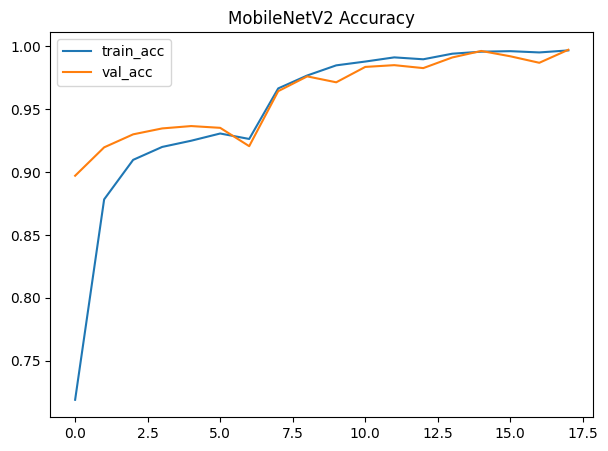

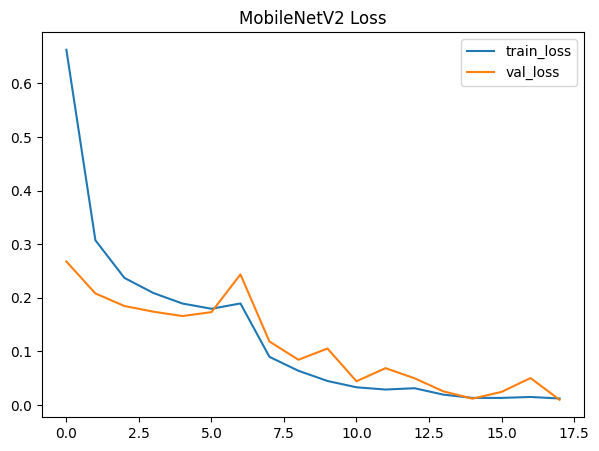

In [ ]:
# ============================================================
# 11) PLOT TRAINING CURVES (DISPLAY + SAVE)
# ============================================================
def combine_histories(h1, h2):
    hist = {}
    for k in h1.history.keys():
        hist[k] = h1.history[k] + h2.history.get(k, [])
    return hist

hist = combine_histories(history1, history2)

acc = hist["accuracy"]
val_acc = hist["val_accuracy"]
loss = hist["loss"]
val_loss = hist["val_loss"]

plt.figure(figsize=(7,5))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend()
plt.title("MobileNetV2 Accuracy")
plt.savefig(os.path.join(OUT_DIR, "mobilenetv2_accuracy.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

plt.figure(figsize=(7,5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend()
plt.title("MobileNetV2 Loss")
plt.savefig(os.path.join(OUT_DIR, "mobilenetv2_loss.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()


In [ ]:
# ============================================================
# 12) LOAD BEST MODEL + EVALUATE ON TEST
# ============================================================
best_model = tf.keras.models.load_model(BEST_LOCAL)

test_loss, test_acc = best_model.evaluate(test_ds, verbose=0)
print(f"✅ CLEAN TEST Accuracy: {test_acc:.4f} | Loss: {test_loss:.4f}")

probs = best_model.predict(test_ds, verbose=0)
y_pred = np.argmax(probs, axis=1)
y_true = test_ds.classes

report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
cm = confusion_matrix(y_true, y_pred)

print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n", cm)

RESULTS_TXT = os.path.join(RESULTS_DIR, "mobilenetv2_results.txt")
with open(RESULTS_TXT, "w") as f:
    f.write(f"CLEAN TEST Accuracy: {test_acc:.4f} | Loss: {test_loss:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(report + "\n\n")
    f.write("Confusion Matrix:\n")
    f.write(str(cm) + "\n")
print("✅ Results saved:", RESULTS_TXT)


✅ CLEAN TEST Accuracy: 0.9967 | Loss: 0.0097

Classification Report:
               precision    recall  f1-score   support

    lung_aca     1.0000    0.9901    0.9950       710
      lung_n     1.0000    1.0000    1.0000       713
    lung_scc     0.9902    1.0000    0.9951       710

    accuracy                         0.9967      2133
   macro avg     0.9967    0.9967    0.9967      2133
weighted avg     0.9968    0.9967    0.9967      2133


Confusion Matrix:
 [[703   0   7]
 [  0 713   0]
 [  0   0 710]]
✅ Results saved: /content/drive/MyDrive/LungCancer_Project/results/mobilenetv2_results.txt


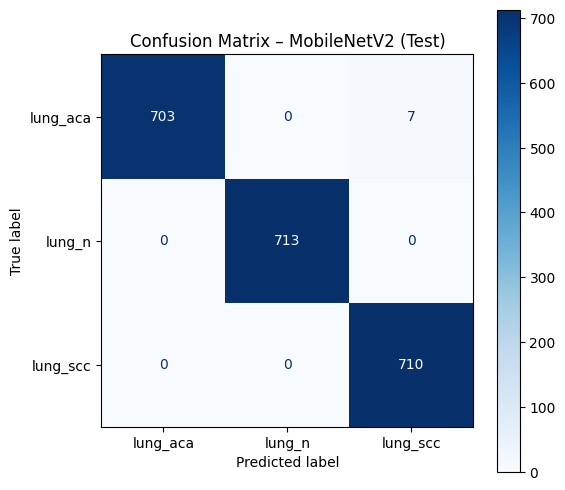

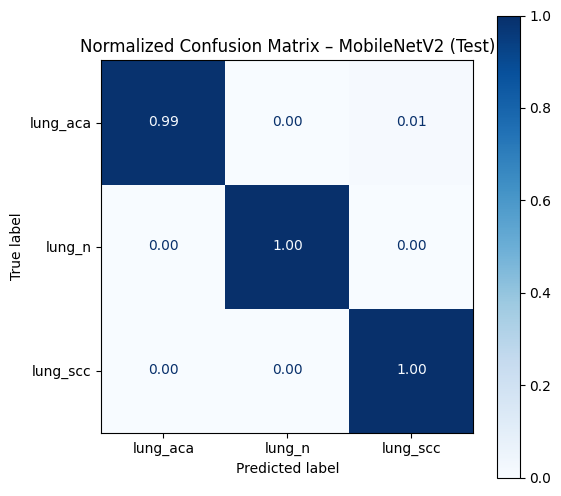

In [ ]:
# ============================================================
# 13) CONFUSION MATRIX PLOTS (DISPLAY + SAVE)
# ============================================================
# raw
fig, ax = plt.subplots(figsize=(6,6))
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix – MobileNetV2 (Test)")
plt.savefig(os.path.join(OUT_DIR, "confusion_matrix.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# normalized
cm_norm = confusion_matrix(y_true, y_pred, normalize="true")
fig, ax = plt.subplots(figsize=(6,6))
disp = ConfusionMatrixDisplay(cm_norm, display_labels=class_names)
disp.plot(ax=ax, cmap="Blues", values_format=".2f")
plt.title("Normalized Confusion Matrix – MobileNetV2 (Test)")
plt.savefig(os.path.join(OUT_DIR, "confusion_matrix_normalized.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

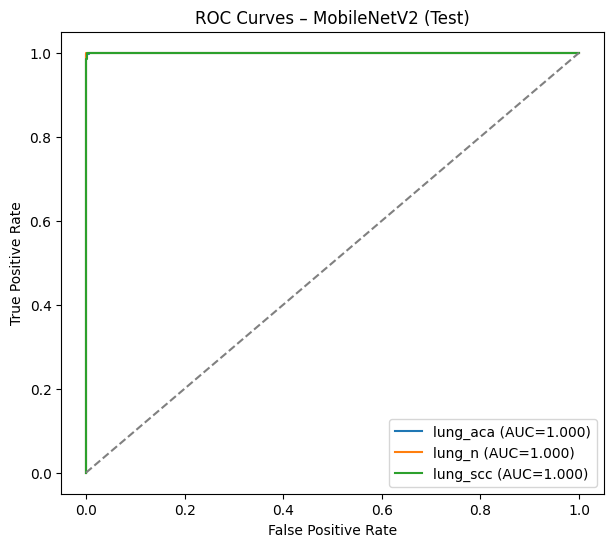

In [ ]:
# ============================================================
# 14) ROC CURVES (OvR) (DISPLAY + SAVE)
# ============================================================
y_true_oh = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))

plt.figure(figsize=(7,6))
for i, cname in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_oh[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cname} (AUC={roc_auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – MobileNetV2 (Test)")
plt.legend()
plt.savefig(os.path.join(OUT_DIR, "roc_curves.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()


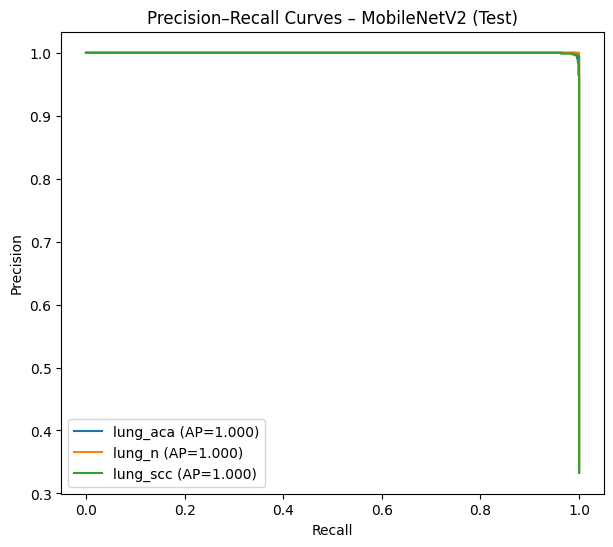

In [ ]:
# ============================================================
# 15) PRECISION–RECALL CURVES (DISPLAY + SAVE)
# ============================================================
plt.figure(figsize=(7,6))
for i, cname in enumerate(class_names):
    prec, rec, _ = precision_recall_curve(y_true_oh[:, i], probs[:, i])
    ap = average_precision_score(y_true_oh[:, i], probs[:, i])
    plt.plot(rec, prec, label=f"{cname} (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves – MobileNetV2 (Test)")
plt.legend()
plt.savefig(os.path.join(OUT_DIR, "pr_curves.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()


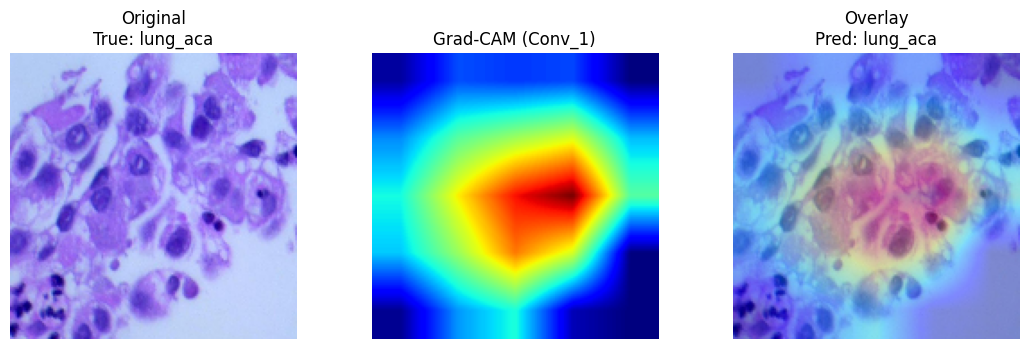

Saved: /content/drive/MyDrive/LungCancer_Project/outputs_figures/MobileNetV2_Conv_1_gradcam_0.png


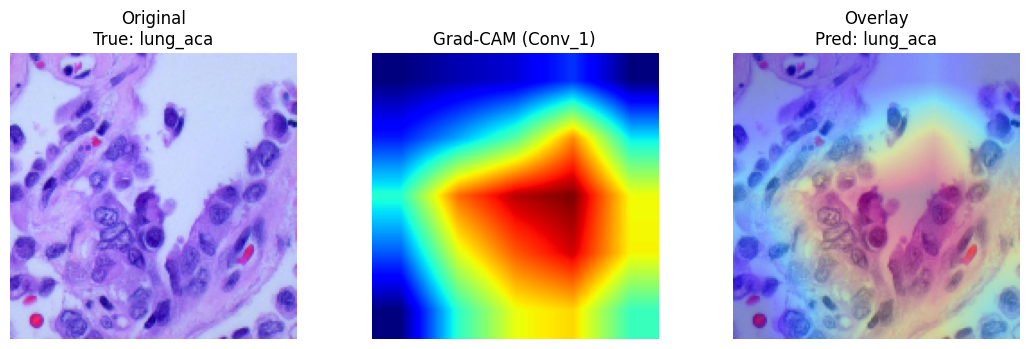

Saved: /content/drive/MyDrive/LungCancer_Project/outputs_figures/MobileNetV2_Conv_1_gradcam_1.png


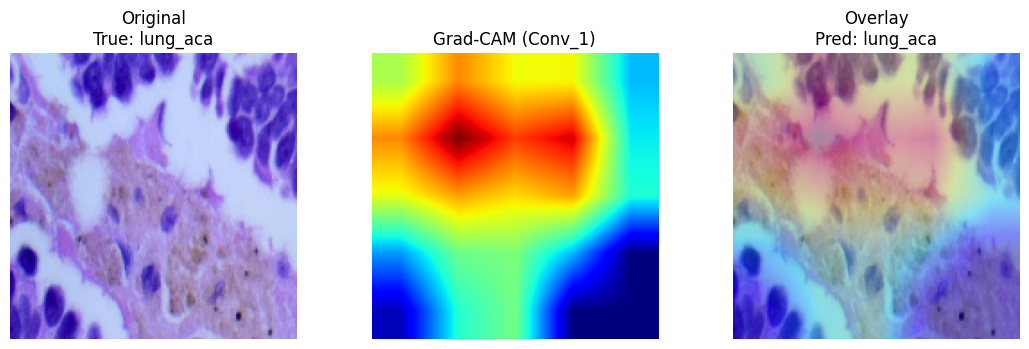

Saved: /content/drive/MyDrive/LungCancer_Project/outputs_figures/MobileNetV2_Conv_1_gradcam_2.png


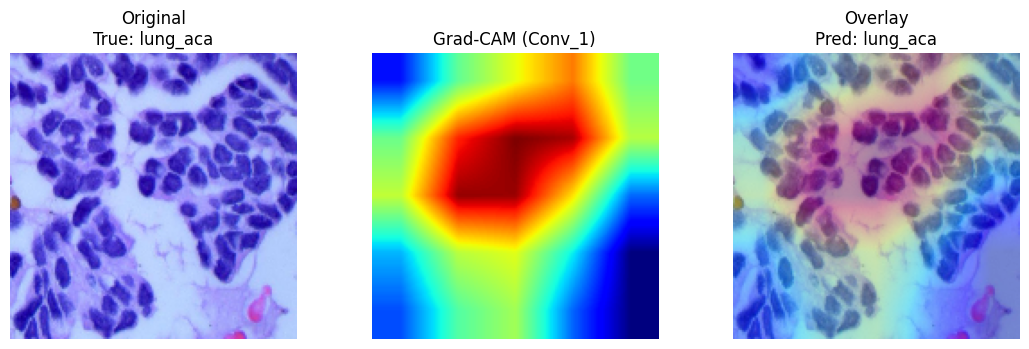

Saved: /content/drive/MyDrive/LungCancer_Project/outputs_figures/MobileNetV2_Conv_1_gradcam_3.png


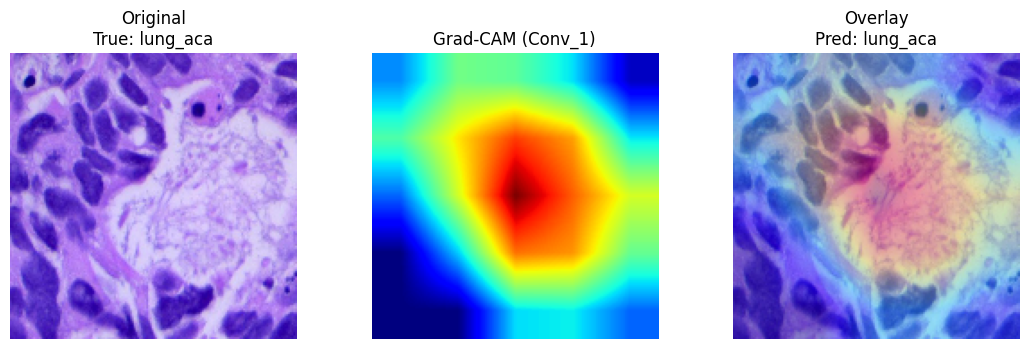

Saved: /content/drive/MyDrive/LungCancer_Project/outputs_figures/MobileNetV2_Conv_1_gradcam_4.png


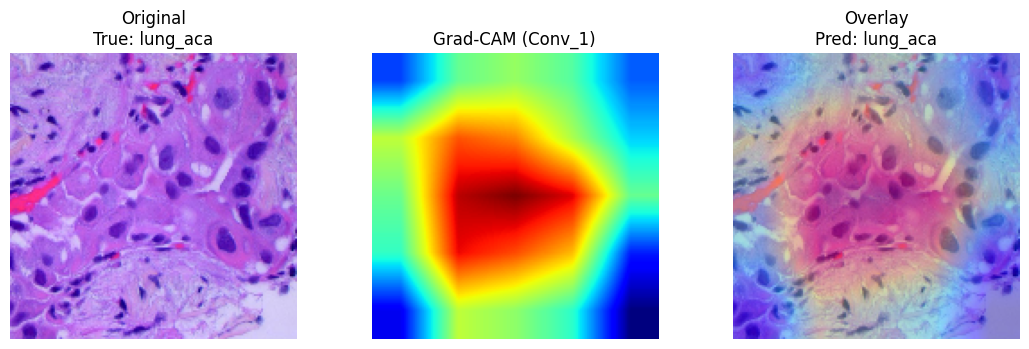

Saved: /content/drive/MyDrive/LungCancer_Project/outputs_figures/MobileNetV2_Conv_1_gradcam_5.png


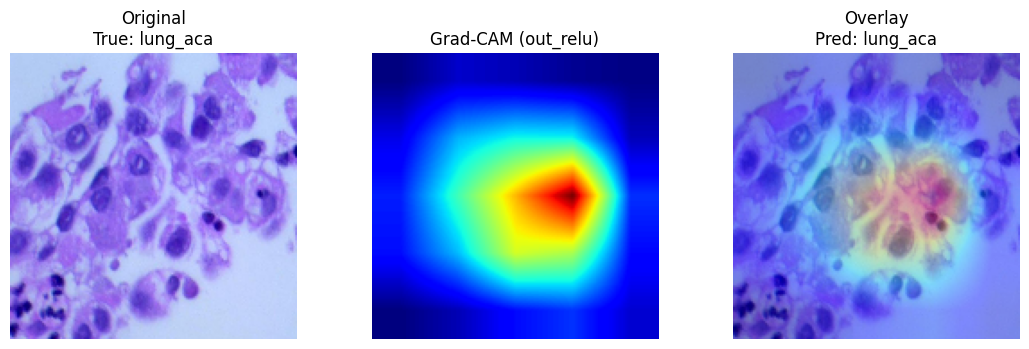

Saved: /content/drive/MyDrive/LungCancer_Project/outputs_figures/MobileNetV2_out_relu_gradcam_0.png


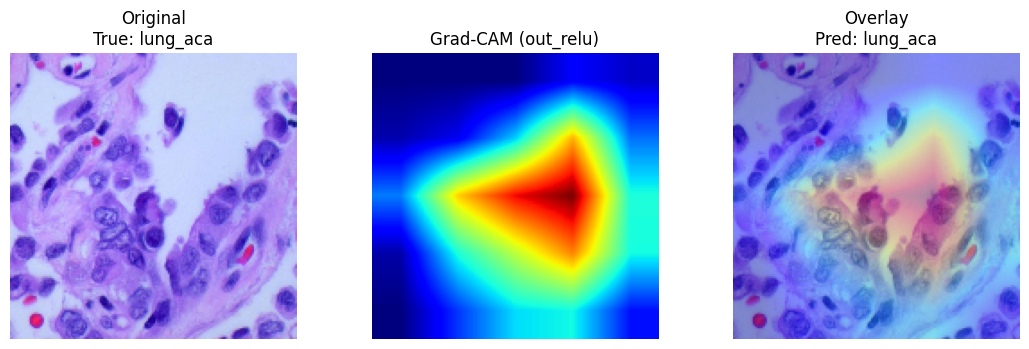

Saved: /content/drive/MyDrive/LungCancer_Project/outputs_figures/MobileNetV2_out_relu_gradcam_1.png


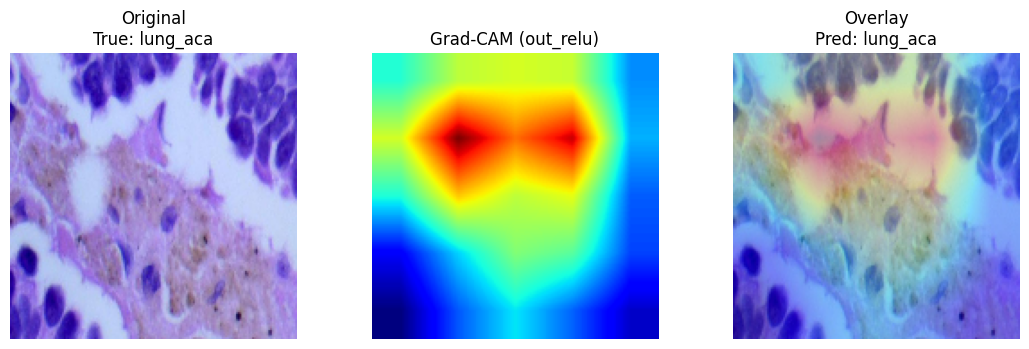

Saved: /content/drive/MyDrive/LungCancer_Project/outputs_figures/MobileNetV2_out_relu_gradcam_2.png


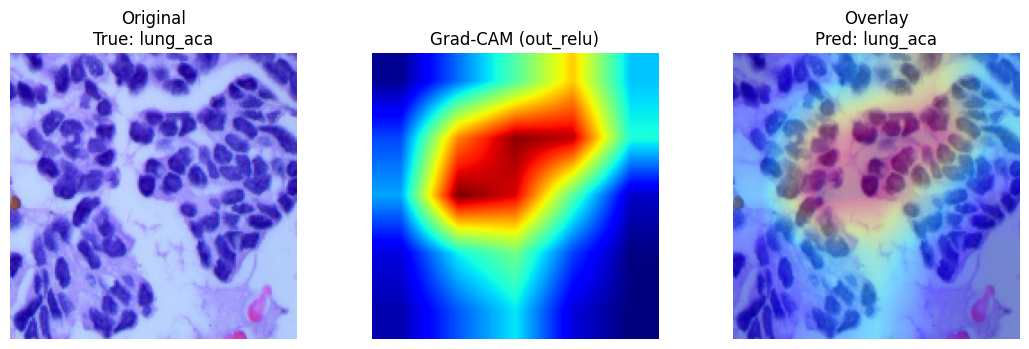

Saved: /content/drive/MyDrive/LungCancer_Project/outputs_figures/MobileNetV2_out_relu_gradcam_3.png


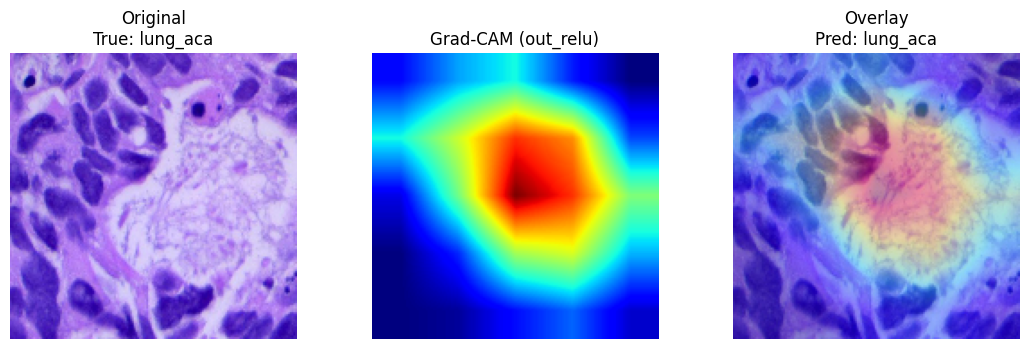

Saved: /content/drive/MyDrive/LungCancer_Project/outputs_figures/MobileNetV2_out_relu_gradcam_4.png


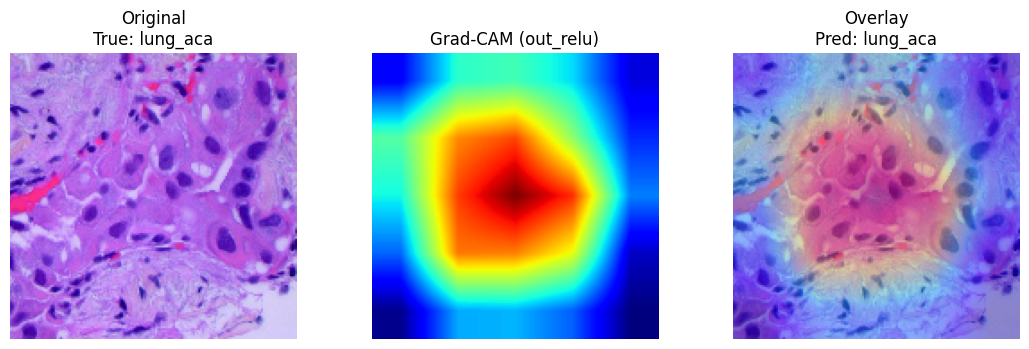

Saved: /content/drive/MyDrive/LungCancer_Project/outputs_figures/MobileNetV2_out_relu_gradcam_5.png


In [ ]:
# ============================================================
# 16) GRAD-CAM (CONNECTED GRAPH) for Conv_1 and out_relu
# ============================================================
def run_gradcam_and_save(target_layer_name="out_relu", n=6, prefix="MobileNetV2"):
    backbone = best_model.layers[0]
    gap      = best_model.layers[1]
    drop     = best_model.layers[2]
    dense    = best_model.layers[3]

    # build once
    _ = backbone(tf.zeros((1,160,160,3)), training=False)

    # backbone multi-output (conv activations + final feat)
    backbone_multi = tf.keras.Model(
        inputs=backbone.input,
        outputs=[backbone.get_layer(target_layer_name).output, backbone.output]
    )

    inp = tf.keras.Input(shape=(160,160,3))
    conv_out, feat = backbone_multi(inp)
    x = gap(feat)
    x = drop(x, training=False)
    preds = dense(x)
    grad_model = tf.keras.Model(inputs=inp, outputs=[conv_out, preds])

    def deprocess(x):
        x = (x + 1.0)/2.0
        return np.clip(x, 0, 1)

    def make_heatmap(img_batch_1):
        img_batch_1 = tf.convert_to_tensor(img_batch_1, dtype=tf.float32)
        with tf.GradientTape() as tape:
            conv_acts, pred = grad_model(img_batch_1, training=False)
            class_index = tf.argmax(pred[0])
            loss = pred[:, class_index]
        grads = tape.gradient(loss, conv_acts)
        pooled = tf.reduce_mean(grads, axis=(0,1,2))
        conv_acts = conv_acts[0]
        heatmap = tf.reduce_sum(conv_acts * pooled, axis=-1)
        heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap)+1e-8)
        return heatmap.numpy(), int(class_index.numpy())

    test_ds.reset()
    xb, yb = test_ds[0]
    n = min(n, xb.shape[0])

    saved_paths = []
    for i in range(n):
        img = xb[i]
        img_in = np.expand_dims(img, axis=0)

        heatmap, pred_idx = make_heatmap(img_in)
        true_idx = int(np.argmax(yb[i]))

        heatmap_resized = tf.image.resize(
            heatmap[..., np.newaxis], (img.shape[0], img.shape[1])
        ).numpy().squeeze()

        disp_img = deprocess(img)

        fig, ax = plt.subplots(1,3, figsize=(11,3.5))
        ax[0].imshow(disp_img); ax[0].set_title(f"Original\nTrue: {class_names[true_idx]}"); ax[0].axis("off")
        ax[1].imshow(heatmap_resized, cmap="jet"); ax[1].set_title(f"Grad-CAM ({target_layer_name})"); ax[1].axis("off")
        ax[2].imshow(disp_img); ax[2].imshow(heatmap_resized, cmap="jet", alpha=0.35)
        ax[2].set_title(f"Overlay\nPred: {class_names[pred_idx]}"); ax[2].axis("off")

        plt.tight_layout()
        save_path = os.path.join(OUT_DIR, f"{prefix}_{target_layer_name}_gradcam_{i}.png")
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.show()
        plt.close()
        print("Saved:", save_path)
        saved_paths.append(save_path)

    return saved_paths

# Run Conv_1 Grad-CAM
conv1_paths = run_gradcam_and_save("Conv_1", n=6, prefix="MobileNetV2")

# Run out_relu Grad-CAM
outrelu_paths = run_gradcam_and_save("out_relu", n=6, prefix="MobileNetV2")



✅ Montage saved: /content/drive/MyDrive/LungCancer_Project/outputs_figures/Top6_outrelu_montage.png


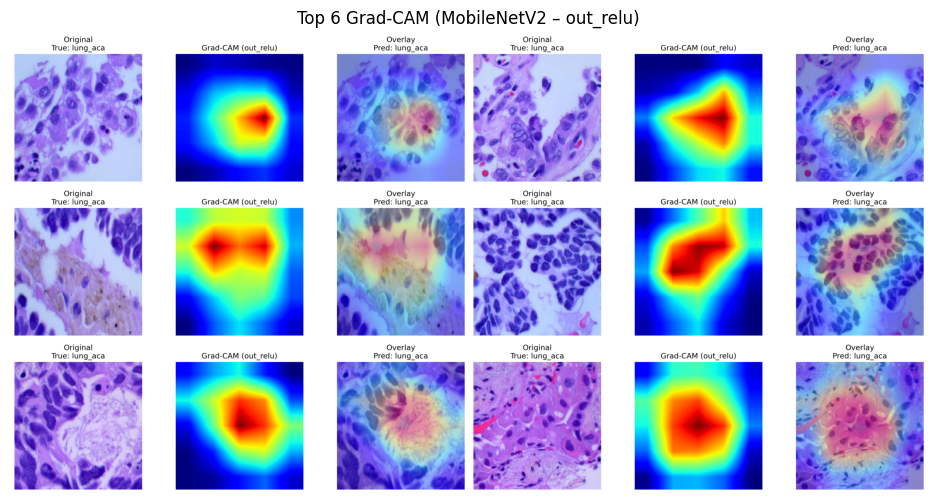

In [ ]:
# ============================================================
# 17) MONTAGE (SAVE + DISPLAY)
# ============================================================
from PIL import Image

def make_montage(paths, out_path, cols=2, title="Montage"):
    imgs = [Image.open(p) for p in paths]
    w, h = imgs[0].size
    rows = (len(imgs) + cols - 1) // cols

    montage = Image.new("RGB", (cols*w, rows*h), (255,255,255))
    for idx, im in enumerate(imgs):
        r = idx // cols
        c = idx % cols
        montage.paste(im, (c*w, r*h))

    montage.save(out_path)
    print("✅ Montage saved:", out_path)

    plt.figure(figsize=(12, 6))
    plt.imshow(montage)
    plt.axis("off")
    plt.title(title)
    plt.show()

# Montage out_relu (recommended for paper)
montage_path = os.path.join(OUT_DIR, "Top6_outrelu_montage.png")
make_montage(outrelu_paths, montage_path, cols=2, title="Top 6 Grad-CAM (MobileNetV2 – out_relu)")

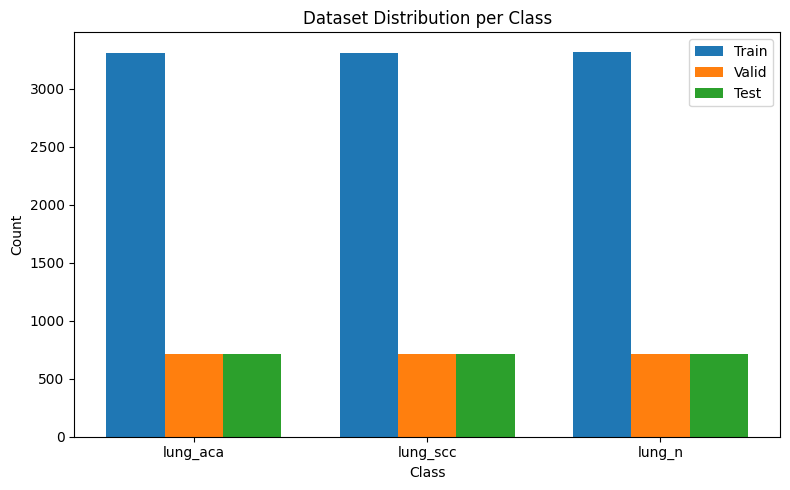

✅ Saved figure to: /content/drive/MyDrive/LungCancer_Project/outputs_figures/mobilenetv2_dataset_distribution.png


In [ ]:
# ================================
# Dataset Distribution per Class
# ================================
import os
import matplotlib.pyplot as plt
import numpy as np

# Update this path ONLY if your clean split folder name is different
DATA_ROOT = "/content/lung_data_clean"   # or lung_data_clean_mobilenet if used
CLASSES = ["lung_aca", "lung_scc", "lung_n"]

splits = ["train", "valid", "test"]
colors = ["tab:blue", "tab:orange", "tab:green"]

# Count images
counts = {split: [] for split in splits}

for cls in CLASSES:
    for split in splits:
        cls_path = os.path.join(DATA_ROOT, split, cls)
        counts[split].append(len(os.listdir(cls_path)))

# Plot
x = np.arange(len(CLASSES))
width = 0.25

plt.figure(figsize=(8, 5))
for i, split in enumerate(splits):
    plt.bar(x + i*width, counts[split], width,
            label=split.capitalize(), color=colors[i])

plt.xticks(x + width, CLASSES)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Dataset Distribution per Class")
plt.legend()
plt.tight_layout()

# Save (paper-ready)
out_path = "/content/drive/MyDrive/LungCancer_Project/outputs_figures/mobilenetv2_dataset_distribution.png"
plt.savefig(out_path, dpi=300)
plt.show()

print("✅ Saved figure to:", out_path)
